##Shroog Alshomrani, Wafa Alrabie , Lama aldohayan

##Notion Link : https://tourmaline-jumper-300.notion.site/Hotel-search-engine-621ea35ea2ca4762827c47d00c0ed7d1?pvs=74


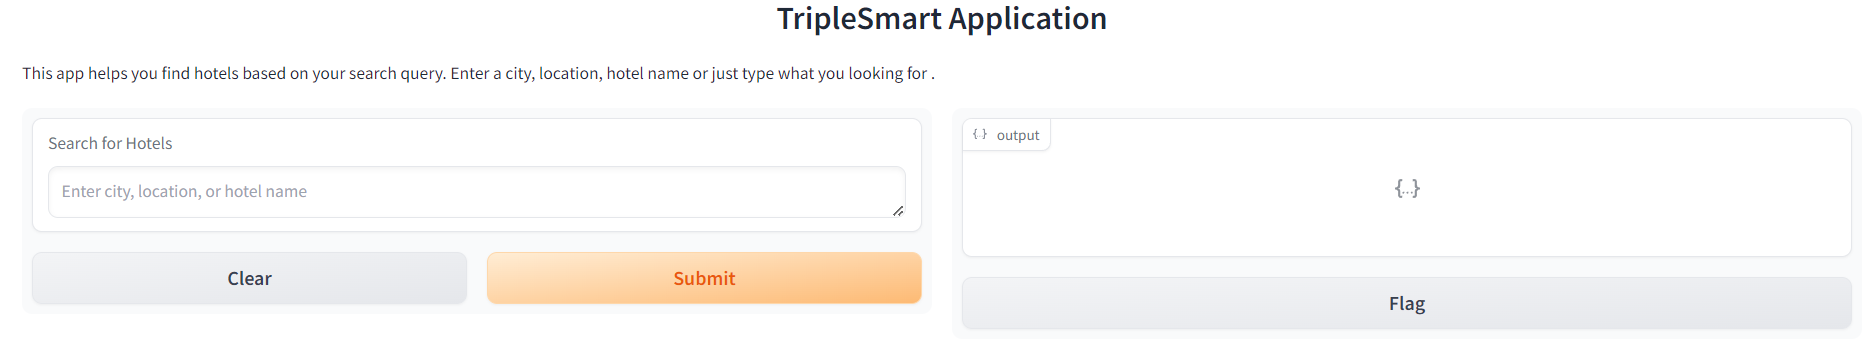
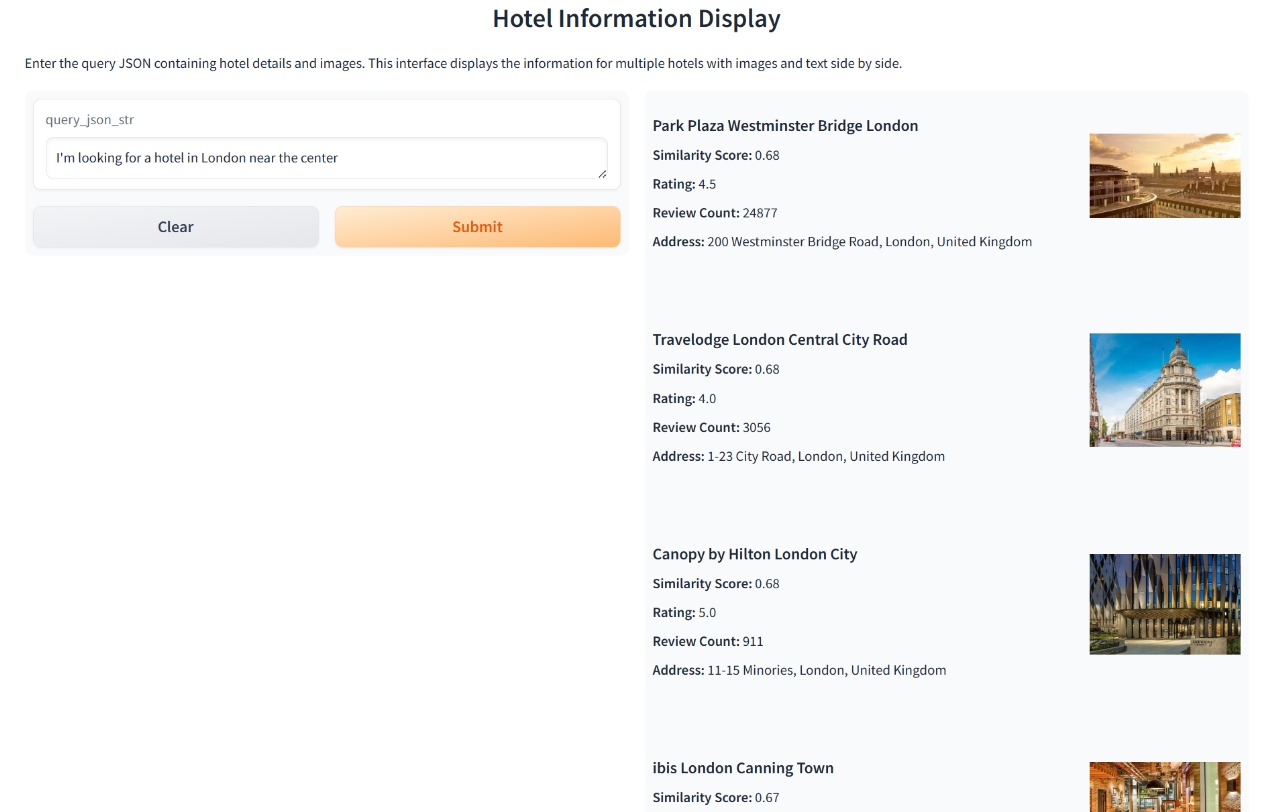



In [3]:
!python -m spacy download en_core_web_sm
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
!pip install openai==0.27.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 85.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
!pip install datasets

In [5]:
!pip install gradio

In [6]:
!pip install -U sentence-transformers rank_bm25

#Import libraries

In [7]:
import json
import pandas as pd
import time
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
from collections import Counter
from heapq import nlargest
import nltk
import numpy as np
from sentence_transformers import SentenceTransformer, util
from openai.embeddings_utils import get_embedding, cosine_similarity

# Load Dataset

In [8]:
from datasets import load_dataset

ds = load_dataset("traversaal-ai-hackathon/hotel_datasets")
data=ds['train']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [9]:
data=pd.DataFrame(data)

In [10]:
data.head()

hotel_name                                  hotel_description  \
0  Romance Istanbul Hotel  Romance Istanbul Hotel has 39 rooms.Every room...   
1  Romance Istanbul Hotel  Romance Istanbul Hotel has 39 rooms.Every room...   
2  Romance Istanbul Hotel  Romance Istanbul Hotel has 39 rooms.Every room...   
3  Romance Istanbul Hotel  Romance Istanbul Hotel has 39 rooms.Every room...   
4  Romance Istanbul Hotel  Romance Istanbul Hotel has 39 rooms.Every room...   

                                        review_title review_text  rate  \
0  An exceptional boutique hotel, great value for...        None   NaN   
1                    You can’t get better than this.        None   NaN   
2                           Exceeds all expectations        None   NaN   
3           Great Location, Fantastic Accommodations        None   NaN   
4              Perfection. It is all in the details.        None   NaN   

         tripdate                                          hotel_url  \
0   February 2020  https://www.tripadvisor.com/Hotel_Review-g2939...   
1      March 2021  https://www.tripadvisor.com/Hotel_Review-g2939...   
2      March 2021  https://www.tripadvisor.com/Hotel_Review-g2939...   
3     August 2021  https://www.tripadvisor.com/Hotel_Review-g2939...   
4       June 2021  https://www.tripadvisor.com/Hotel_Review-g2939...   

                                         hotel_image  \
0  https://media-cdn.tripadvisor.com/media/photo-...   
1  https://media-cdn.tripadvisor.com/media/photo-...   
2  https://media-cdn.tripadvisor.com/media/photo-...   
3  https://media-cdn.tripadvisor.com/media/photo-...   
4  https://media-cdn.tripadvisor.com/media/photo-...   

                                         price_range  rating_value  \
0  $ (Based on Average Nightly Rates for a Standa...           5.0   
1  $ (Based on Average Nightly Rates for a Standa...           5.0   
2  $ (Based on Average Nightly Rates for a Standa...           5.0   
3  $ (Based on Average Nightly Rates for a Standa...           5.0   
4  $ (Based on Average Nightly Rates for a Standa...           5.0   

   review_count                 street_address  locality  country  
0          4023  Hudavendigar Cd. No:5 Sirkeci  Istanbul  Turkiye  
1          4023  Hudavendigar Cd. No:5 Sirkeci  Istanbul  Turkiye  
2          4023  Hudavendigar Cd. No:5 Sirkeci  Istanbul  Turkiye  
3          4023  Hudavendigar Cd. No:5 Sirkeci  Istanbul  Turkiye  
4          4023  Hudavendigar Cd. No:5 Sirkeci  Istanbul  Turkiye

In [11]:
!apt-get install -y fonts-freefont-ttf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-freefont-ttf is already the newest version (20120503-10build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


# Exploring data set By EDA

In [12]:
! pip install --upgrade Pillow

In [13]:
!pip install ydata_profiling

In [14]:
#Ceate a Comperhensive  report
from ydata_profiling import ProfileReport

EDA_df = ProfileReport(data,minimal=True)
EDA_df

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
data.shape

(5997, 14)

In [16]:
data.country.value_counts()

country
United States     2397
United Kingdom    1200
France            1200
Turkiye            720
Türkiye            480
Name: count, dtype: int64

In [17]:
data.locality.value_counts()

locality
Istanbul         1200
San Francisco    1200
London           1200
Paris            1200
New York City    1197
Name: count, dtype: int64

In [18]:
data['country'] = data['country'].replace('Türkiye', 'Turkiye')

In [19]:
# drop duplicates
data=data.drop_duplicates()

In [20]:
data.head()

hotel_name                                  hotel_description  \
0  Romance Istanbul Hotel  Romance Istanbul Hotel has 39 rooms.Every room...   
1  Romance Istanbul Hotel  Romance Istanbul Hotel has 39 rooms.Every room...   
2  Romance Istanbul Hotel  Romance Istanbul Hotel has 39 rooms.Every room...   
3  Romance Istanbul Hotel  Romance Istanbul Hotel has 39 rooms.Every room...   
4  Romance Istanbul Hotel  Romance Istanbul Hotel has 39 rooms.Every room...   

                                        review_title review_text  rate  \
0  An exceptional boutique hotel, great value for...        None   NaN   
1                    You can’t get better than this.        None   NaN   
2                           Exceeds all expectations        None   NaN   
3           Great Location, Fantastic Accommodations        None   NaN   
4              Perfection. It is all in the details.        None   NaN   

         tripdate                                          hotel_url  \
0   February 2020  https://www.tripadvisor.com/Hotel_Review-g2939...   
1      March 2021  https://www.tripadvisor.com/Hotel_Review-g2939...   
2      March 2021  https://www.tripadvisor.com/Hotel_Review-g2939...   
3     August 2021  https://www.tripadvisor.com/Hotel_Review-g2939...   
4       June 2021  https://www.tripadvisor.com/Hotel_Review-g2939...   

                                         hotel_image  \
0  https://media-cdn.tripadvisor.com/media/photo-...   
1  https://media-cdn.tripadvisor.com/media/photo-...   
2  https://media-cdn.tripadvisor.com/media/photo-...   
3  https://media-cdn.tripadvisor.com/media/photo-...   
4  https://media-cdn.tripadvisor.com/media/photo-...   

                                         price_range  rating_value  \
0  $ (Based on Average Nightly Rates for a Standa...           5.0   
1  $ (Based on Average Nightly Rates for a Standa...           5.0   
2  $ (Based on Average Nightly Rates for a Standa...           5.0   
3  $ (Based on Average Nightly Rates for a Standa...           5.0   
4  $ (Based on Average Nightly Rates for a Standa...           5.0   

   review_count                 street_address  locality  country  
0          4023  Hudavendigar Cd. No:5 Sirkeci  Istanbul  Turkiye  
1          4023  Hudavendigar Cd. No:5 Sirkeci  Istanbul  Turkiye  
2          4023  Hudavendigar Cd. No:5 Sirkeci  Istanbul  Turkiye  
3          4023  Hudavendigar Cd. No:5 Sirkeci  Istanbul  Turkiye  
4          4023  Hudavendigar Cd. No:5 Sirkeci  Istanbul  Turkiye

In [21]:
data.shape

(5997, 14)

In [22]:
data.hotel_name.value_counts()

hotel_name
Romance Istanbul Hotel                      40
Motto by Hilton New York City Chelsea       40
The Bryant Park Hotel                       40
Pod Times Square                            40
Tempo by Hilton New York Times Square       40
                                            ..
San Francisco Marriott Fisherman's Wharf    40
Hilton San Francisco Financial District     40
The Donatello                               40
Hotel Campanile Paris Bercy Village         40
The FIDI Hotel                              37
Name: count, Length: 150, dtype: int64

In [23]:
data.rating_value.value_counts()

rating_value
4.5    2677
5.0    1520
4.0    1520
3.5     200
3.0      80
Name: count, dtype: int64

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
!mkdir /content/drive/MyDrive/Semantic_Search_ass

In [26]:
data['review_text'].unique().shape

(4868,)

In [27]:
data['review_title'].unique().shape

(5314,)

# Compine reviews

In [28]:
data["combined_review"] = data.apply(
    lambda row: ("title: " + row.review_title.strip() + "; " if pd.notna(row.review_title) and row.review_title.strip() else "") +
                ("review: " + row.review_text.strip() if pd.notna(row.review_text) and row.review_text.strip() else ""),axis=1
)
data.head()

hotel_name                                  hotel_description  \
0  Romance Istanbul Hotel  Romance Istanbul Hotel has 39 rooms.Every room...   
1  Romance Istanbul Hotel  Romance Istanbul Hotel has 39 rooms.Every room...   
2  Romance Istanbul Hotel  Romance Istanbul Hotel has 39 rooms.Every room...   
3  Romance Istanbul Hotel  Romance Istanbul Hotel has 39 rooms.Every room...   
4  Romance Istanbul Hotel  Romance Istanbul Hotel has 39 rooms.Every room...   

                                        review_title review_text  rate  \
0  An exceptional boutique hotel, great value for...        None   NaN   
1                    You can’t get better than this.        None   NaN   
2                           Exceeds all expectations        None   NaN   
3           Great Location, Fantastic Accommodations        None   NaN   
4              Perfection. It is all in the details.        None   NaN   

         tripdate                                          hotel_url  \
0   February 2020  https://www.tripadvisor.com/Hotel_Review-g2939...   
1      March 2021  https://www.tripadvisor.com/Hotel_Review-g2939...   
2      March 2021  https://www.tripadvisor.com/Hotel_Review-g2939...   
3     August 2021  https://www.tripadvisor.com/Hotel_Review-g2939...   
4       June 2021  https://www.tripadvisor.com/Hotel_Review-g2939...   

                                         hotel_image  \
0  https://media-cdn.tripadvisor.com/media/photo-...   
1  https://media-cdn.tripadvisor.com/media/photo-...   
2  https://media-cdn.tripadvisor.com/media/photo-...   
3  https://media-cdn.tripadvisor.com/media/photo-...   
4  https://media-cdn.tripadvisor.com/media/photo-...   

                                         price_range  rating_value  \
0  $ (Based on Average Nightly Rates for a Standa...           5.0   
1  $ (Based on Average Nightly Rates for a Standa...           5.0   
2  $ (Based on Average Nightly Rates for a Standa...           5.0   
3  $ (Based on Average Nightly Rates for a Standa...           5.0   
4  $ (Based on Average Nightly Rates for a Standa...           5.0   

   review_count                 street_address  locality  country  \
0          4023  Hudavendigar Cd. No:5 Sirkeci  Istanbul  Turkiye   
1          4023  Hudavendigar Cd. No:5 Sirkeci  Istanbul  Turkiye   
2          4023  Hudavendigar Cd. No:5 Sirkeci  Istanbul  Turkiye   
3          4023  Hudavendigar Cd. No:5 Sirkeci  Istanbul  Turkiye   
4          4023  Hudavendigar Cd. No:5 Sirkeci  Istanbul  Turkiye   

                                     combined_review  
0  title: An exceptional boutique hotel, great va...  
1           title: You can’t get better than this.;   
2                  title: Exceeds all expectations;   
3  title: Great Location, Fantastic Accommodations;   
4     title: Perfection. It is all in the details.;

In [29]:
data.combined_review.unique().shape

(5929,)

##Preprocessing reviews before starting embedding;
# extract text and numbers like rating values
# remove punctuations
#convert text to lower case

In [30]:
import re

df_combined = data.copy()

df_combined['combined_review'] = df_combined['combined_review'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',str(x)))

# Translate all the "combined" column to lower case.
def lower_case(input_str):
    input_str = input_str.lower()
    return input_str

df_combined['combined_review']= df_combined['combined_review'].apply(lambda x: lower_case(x))

In [31]:
df_combined.head()

hotel_name                                  hotel_description  \
0  Romance Istanbul Hotel  Romance Istanbul Hotel has 39 rooms.Every room...   
1  Romance Istanbul Hotel  Romance Istanbul Hotel has 39 rooms.Every room...   
2  Romance Istanbul Hotel  Romance Istanbul Hotel has 39 rooms.Every room...   
3  Romance Istanbul Hotel  Romance Istanbul Hotel has 39 rooms.Every room...   
4  Romance Istanbul Hotel  Romance Istanbul Hotel has 39 rooms.Every room...   

                                        review_title review_text  rate  \
0  An exceptional boutique hotel, great value for...        None   NaN   
1                    You can’t get better than this.        None   NaN   
2                           Exceeds all expectations        None   NaN   
3           Great Location, Fantastic Accommodations        None   NaN   
4              Perfection. It is all in the details.        None   NaN   

         tripdate                                          hotel_url  \
0   February 2020  https://www.tripadvisor.com/Hotel_Review-g2939...   
1      March 2021  https://www.tripadvisor.com/Hotel_Review-g2939...   
2      March 2021  https://www.tripadvisor.com/Hotel_Review-g2939...   
3     August 2021  https://www.tripadvisor.com/Hotel_Review-g2939...   
4       June 2021  https://www.tripadvisor.com/Hotel_Review-g2939...   

                                         hotel_image  \
0  https://media-cdn.tripadvisor.com/media/photo-...   
1  https://media-cdn.tripadvisor.com/media/photo-...   
2  https://media-cdn.tripadvisor.com/media/photo-...   
3  https://media-cdn.tripadvisor.com/media/photo-...   
4  https://media-cdn.tripadvisor.com/media/photo-...   

                                         price_range  rating_value  \
0  $ (Based on Average Nightly Rates for a Standa...           5.0   
1  $ (Based on Average Nightly Rates for a Standa...           5.0   
2  $ (Based on Average Nightly Rates for a Standa...           5.0   
3  $ (Based on Average Nightly Rates for a Standa...           5.0   
4  $ (Based on Average Nightly Rates for a Standa...           5.0   

   review_count                 street_address  locality  country  \
0          4023  Hudavendigar Cd. No:5 Sirkeci  Istanbul  Turkiye   
1          4023  Hudavendigar Cd. No:5 Sirkeci  Istanbul  Turkiye   
2          4023  Hudavendigar Cd. No:5 Sirkeci  Istanbul  Turkiye   
3          4023  Hudavendigar Cd. No:5 Sirkeci  Istanbul  Turkiye   
4          4023  Hudavendigar Cd. No:5 Sirkeci  Istanbul  Turkiye   

                                     combined_review  
0  title an exceptional boutique hotel great valu...  
1               title you cant get better than this   
2                    title exceeds all expectations   
3     title great location fantastic accommodations   
4         title perfection it is all in the details

In [32]:
data.combined_review.unique()

array(['title: An exceptional boutique hotel, great value for your money; ',
       'title: You can’t get better than this.; ',
       'title: Exceeds all expectations; ', ...,
       'title: Great location; review: Stayed here for a few days and it is a great location to get around Paris. The metro is a few hundred metres from the front door. The staff at the hotel are knowledgeable, friendly and very accommodating. Highly recommend this hotel.',
       'title: For one night only; review: We stayed here for one night on our way to Italy and that was enough. The room was clean and quite comfortable but very small like a poor relation of Premier Inn.  It’s in an area without much to offer in terms of anything to do in the evening and the hotel doesn’t really offer much either.  Depends what you’re after and it is perfectly adequate just not somewhere you want to do anything other than sleep.',
       'title: Nice hotel in Paris Bercy; review: The Hotel is close to the metro station Cour

In [33]:
data.to_csv('/content/drive/MyDrive/Semantic_Search_ass/hotel_3.csv',index=False)

In [34]:
from sentence_transformers import SentenceTransformer #import model

model = SentenceTransformer("nomic-ai/nomic-embed-text-v1.5",trust_remote_code=True)

modules.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/140 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/71.2k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

configuration_hf_nomic_bert.py:   0%|          | 0.00/1.96k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nomic-ai/nomic-bert-2048:
- configuration_hf_nomic_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_hf_nomic_bert.py:   0%|          | 0.00/84.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nomic-ai/nomic-bert-2048:
- modeling_hf_nomic_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/547M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

In [35]:
import json
from sentence_transformers import SentenceTransformer, CrossEncoder, util
import gzip
import os
import torch

embedder =model

# Use the GPU if available
if not torch.cuda.is_available():
    print("Warning: No GPU found. Please add GPU to your notebook")
else:
  print("GPU Found!")
  embedder =  embedder.to('cuda')

GPU Found!


In [37]:
startTime = time.time()

data["embedding_reviews"] = data.combined_review.apply(lambda x: embedder.encode(x))

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

Execution time in seconds: 121.59374523162842


In [38]:
data.head()

hotel_name                                  hotel_description  \
0  Romance Istanbul Hotel  Romance Istanbul Hotel has 39 rooms.Every room...   
1  Romance Istanbul Hotel  Romance Istanbul Hotel has 39 rooms.Every room...   
2  Romance Istanbul Hotel  Romance Istanbul Hotel has 39 rooms.Every room...   
3  Romance Istanbul Hotel  Romance Istanbul Hotel has 39 rooms.Every room...   
4  Romance Istanbul Hotel  Romance Istanbul Hotel has 39 rooms.Every room...   

                                        review_title review_text  rate  \
0  An exceptional boutique hotel, great value for...        None   NaN   
1                    You can’t get better than this.        None   NaN   
2                           Exceeds all expectations        None   NaN   
3           Great Location, Fantastic Accommodations        None   NaN   
4              Perfection. It is all in the details.        None   NaN   

         tripdate                                          hotel_url  \
0   February 2020  https://www.tripadvisor.com/Hotel_Review-g2939...   
1      March 2021  https://www.tripadvisor.com/Hotel_Review-g2939...   
2      March 2021  https://www.tripadvisor.com/Hotel_Review-g2939...   
3     August 2021  https://www.tripadvisor.com/Hotel_Review-g2939...   
4       June 2021  https://www.tripadvisor.com/Hotel_Review-g2939...   

                                         hotel_image  \
0  https://media-cdn.tripadvisor.com/media/photo-...   
1  https://media-cdn.tripadvisor.com/media/photo-...   
2  https://media-cdn.tripadvisor.com/media/photo-...   
3  https://media-cdn.tripadvisor.com/media/photo-...   
4  https://media-cdn.tripadvisor.com/media/photo-...   

                                         price_range  rating_value  \
0  $ (Based on Average Nightly Rates for a Standa...           5.0   
1  $ (Based on Average Nightly Rates for a Standa...           5.0   
2  $ (Based on Average Nightly Rates for a Standa...           5.0   
3  $ (Based on Average Nightly Rates for a Standa...           5.0   
4  $ (Based on Average Nightly Rates for a Standa...           5.0   

   review_count                 street_address  locality  country  \
0          4023  Hudavendigar Cd. No:5 Sirkeci  Istanbul  Turkiye   
1          4023  Hudavendigar Cd. No:5 Sirkeci  Istanbul  Turkiye   
2          4023  Hudavendigar Cd. No:5 Sirkeci  Istanbul  Turkiye   
3          4023  Hudavendigar Cd. No:5 Sirkeci  Istanbul  Turkiye   
4          4023  Hudavendigar Cd. No:5 Sirkeci  Istanbul  Turkiye   

                                     combined_review  \
0  title: An exceptional boutique hotel, great va...   
1           title: You can’t get better than this.;    
2                  title: Exceeds all expectations;    
3  title: Great Location, Fantastic Accommodations;    
4     title: Perfection. It is all in the details.;    

                                   embedding_reviews  
0  [-0.8809357, 1.7398549, -4.688045, 0.22412974,...  
1  [1.7030693, 0.47152752, -4.0451517, -0.0250990...  
2  [0.6204792, 1.4922241, -4.4574995, 0.23324388,...  
3  [-0.39630893, 1.4465358, -4.73181, -0.37217984...  
4  [1.7434638, 0.6060874, -3.9844537, -0.40010685...

In [39]:
data.review_count.unique()

array([ 4023,  4975,  8558,  7512,  2797,  1269,   306,  7594,  5032,
         719,   166,  4662,   197,  3648,  1315,   934,   850,   372,
        1125,   692,  1148,   625,  1729,  2108,  1245,  1461,   948,
        2412,   123,   219,  2016,   693,  1046,   962,   603,  5977,
        6852,  1585,   581,   789,  3636,  2600,  1084,  4693,  7814,
         659,  5070,  1054,   534,   892,  8192,  1878,  5006,  3036,
        1473,  1389,  2427,  1012,  3911,   308,  4166,  4153,  3242,
        1654,  1037,   911,  4167,  5937,  5247,  2968,  1575,  7453,
       13654,   395,   742,  2448,  7184, 13530,  1020,  3056, 11553,
        1221,  2053,   920,  1372, 24877,   786,  2133,  3515,   881,
         974,  3375,  4069,  4595,   978,  2900,  5037,  2561,   203,
        6199,  6405,  8667, 13493,  1188,  6948, 15560,  2525, 16122,
        7569,  3058,  2458, 12683,  8578,  4451,  3645, 12188,  5425,
        4936,  8748,    39,  2985,  6929,  2265,  1502,   641,  3755,
        2196,  1190,

In [40]:
data.rating_value.unique()

array([5. , 4.5, 4. , 3. , 3.5])

In [41]:
data.to_pickle('/content/drive/MyDrive/Semantic_Search_ass/df.pkl')    #to save the dataframe, df to 123.pkl

In [42]:
df_with_embedding = pd.read_pickle('/content/drive/MyDrive/Semantic_Search_ass/df.pkl') #to load 123.pkl back to the dataframe df

In [43]:
df_with_embedding["combined_summary"] = df_with_embedding.apply(
    lambda row: ("hotel_name: " + row.hotel_name.strip() + "; " if pd.notna(row.hotel_name) and row.hotel_name.strip() else "") +
    ("hotel_description: " + row.hotel_description.strip() + "; " if pd.notna(row.hotel_description) and row.hotel_description.strip() else "") +
                 ("rating_value: " + str(row.rating_value) if pd.notna(str(row.rating_value)) and row.rating_value else "")+
                  ("review_count: " + str(row.review_count) if pd.notna(str(row.review_count)) and row.review_count else "")+
                   ("street_address: " + row.street_address.strip() if pd.notna(row.street_address) and row.street_address.strip() else "")+
                    ("City: " + row.locality.strip() if pd.notna(row.locality) and row.locality.strip() else "")+
                     ("country: " + row.country.strip() if pd.notna(row.country) and row.country.strip() else ""), axis=1
)

df_with_embedding.head()

hotel_name                                  hotel_description  \
0  Romance Istanbul Hotel  Romance Istanbul Hotel has 39 rooms.Every room...   
1  Romance Istanbul Hotel  Romance Istanbul Hotel has 39 rooms.Every room...   
2  Romance Istanbul Hotel  Romance Istanbul Hotel has 39 rooms.Every room...   
3  Romance Istanbul Hotel  Romance Istanbul Hotel has 39 rooms.Every room...   
4  Romance Istanbul Hotel  Romance Istanbul Hotel has 39 rooms.Every room...   

                                        review_title review_text  rate  \
0  An exceptional boutique hotel, great value for...        None   NaN   
1                    You can’t get better than this.        None   NaN   
2                           Exceeds all expectations        None   NaN   
3           Great Location, Fantastic Accommodations        None   NaN   
4              Perfection. It is all in the details.        None   NaN   

         tripdate                                          hotel_url  \
0   February 2020  https://www.tripadvisor.com/Hotel_Review-g2939...   
1      March 2021  https://www.tripadvisor.com/Hotel_Review-g2939...   
2      March 2021  https://www.tripadvisor.com/Hotel_Review-g2939...   
3     August 2021  https://www.tripadvisor.com/Hotel_Review-g2939...   
4       June 2021  https://www.tripadvisor.com/Hotel_Review-g2939...   

                                         hotel_image  \
0  https://media-cdn.tripadvisor.com/media/photo-...   
1  https://media-cdn.tripadvisor.com/media/photo-...   
2  https://media-cdn.tripadvisor.com/media/photo-...   
3  https://media-cdn.tripadvisor.com/media/photo-...   
4  https://media-cdn.tripadvisor.com/media/photo-...   

                                         price_range  rating_value  \
0  $ (Based on Average Nightly Rates for a Standa...           5.0   
1  $ (Based on Average Nightly Rates for a Standa...           5.0   
2  $ (Based on Average Nightly Rates for a Standa...           5.0   
3  $ (Based on Average Nightly Rates for a Standa...           5.0   
4  $ (Based on Average Nightly Rates for a Standa...           5.0   

   review_count                 street_address  locality  country  \
0          4023  Hudavendigar Cd. No:5 Sirkeci  Istanbul  Turkiye   
1          4023  Hudavendigar Cd. No:5 Sirkeci  Istanbul  Turkiye   
2          4023  Hudavendigar Cd. No:5 Sirkeci  Istanbul  Turkiye   
3          4023  Hudavendigar Cd. No:5 Sirkeci  Istanbul  Turkiye   
4          4023  Hudavendigar Cd. No:5 Sirkeci  Istanbul  Turkiye   

                                     combined_review  \
0  title: An exceptional boutique hotel, great va...   
1           title: You can’t get better than this.;    
2                  title: Exceeds all expectations;    
3  title: Great Location, Fantastic Accommodations;    
4     title: Perfection. It is all in the details.;    

                                   embedding_reviews  \
0  [-0.8809357, 1.7398549, -4.688045, 0.22412974,...   
1  [1.7030693, 0.47152752, -4.0451517, -0.0250990...   
2  [0.6204792, 1.4922241, -4.4574995, 0.23324388,...   
3  [-0.39630893, 1.4465358, -4.73181, -0.37217984...   
4  [1.7434638, 0.6060874, -3.9844537, -0.40010685...   

                                    combined_summary  
0  hotel_name: Romance Istanbul Hotel; hotel_desc...  
1  hotel_name: Romance Istanbul Hotel; hotel_desc...  
2  hotel_name: Romance Istanbul Hotel; hotel_desc...  
3  hotel_name: Romance Istanbul Hotel; hotel_desc...  
4  hotel_name: Romance Istanbul Hotel; hotel_desc...

In [44]:
df_with_embedding['combined_summary'][0]

'hotel_name: Romance Istanbul Hotel; hotel_description: Romance Istanbul Hotel has 39 rooms.Every room is elegantly furnished and harmonizes the modern life style with the traditional Ottoman touch. Romance Istanbul sits at the intersection of the old city’s most important part. With its luxuriously inspiring design and landmark old city location, steeped in the history of its surroundings, Romance Istanbul Hotel welcomes you with exceptional designed rooms and world-renowned Turkish hospitality. Our colleagues deliver the most personal service. It is perfectly placed and perfectly designed to enhance all that Istanbul has to offer. Each room offers a private bathroom and shower. Each is equipped with a satellite TV and free wifi connection. The rooms size change between 20 m2 and 45 m2. It includes 7 suite rooms: 1 Royal Suite, 4 Grand Suite, 1 Romance Suite and 1 Premium Suite, 2 Luxury Room With Terrace, 22 Deluxe Room, 8 City Room.; rating_value: 5.0review_count: 4023street_address

In [45]:
import re

df_with_embedding2 = df_with_embedding.copy()

df_with_embedding2['combined_summary'] = df_with_embedding['combined_summary'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',str(x)))

# Translate all the "combined" column to lower case.
def lower_case(input_str):
    input_str = input_str.lower()
    return input_str

df_with_embedding2['combined_summary']= df_with_embedding2['combined_summary'].apply(lambda x: lower_case(x))

In [46]:
df_with_embedding2.head()

hotel_name                                  hotel_description  \
0  Romance Istanbul Hotel  Romance Istanbul Hotel has 39 rooms.Every room...   
1  Romance Istanbul Hotel  Romance Istanbul Hotel has 39 rooms.Every room...   
2  Romance Istanbul Hotel  Romance Istanbul Hotel has 39 rooms.Every room...   
3  Romance Istanbul Hotel  Romance Istanbul Hotel has 39 rooms.Every room...   
4  Romance Istanbul Hotel  Romance Istanbul Hotel has 39 rooms.Every room...   

                                        review_title review_text  rate  \
0  An exceptional boutique hotel, great value for...        None   NaN   
1                    You can’t get better than this.        None   NaN   
2                           Exceeds all expectations        None   NaN   
3           Great Location, Fantastic Accommodations        None   NaN   
4              Perfection. It is all in the details.        None   NaN   

         tripdate                                          hotel_url  \
0   February 2020  https://www.tripadvisor.com/Hotel_Review-g2939...   
1      March 2021  https://www.tripadvisor.com/Hotel_Review-g2939...   
2      March 2021  https://www.tripadvisor.com/Hotel_Review-g2939...   
3     August 2021  https://www.tripadvisor.com/Hotel_Review-g2939...   
4       June 2021  https://www.tripadvisor.com/Hotel_Review-g2939...   

                                         hotel_image  \
0  https://media-cdn.tripadvisor.com/media/photo-...   
1  https://media-cdn.tripadvisor.com/media/photo-...   
2  https://media-cdn.tripadvisor.com/media/photo-...   
3  https://media-cdn.tripadvisor.com/media/photo-...   
4  https://media-cdn.tripadvisor.com/media/photo-...   

                                         price_range  rating_value  \
0  $ (Based on Average Nightly Rates for a Standa...           5.0   
1  $ (Based on Average Nightly Rates for a Standa...           5.0   
2  $ (Based on Average Nightly Rates for a Standa...           5.0   
3  $ (Based on Average Nightly Rates for a Standa...           5.0   
4  $ (Based on Average Nightly Rates for a Standa...           5.0   

   review_count                 street_address  locality  country  \
0          4023  Hudavendigar Cd. No:5 Sirkeci  Istanbul  Turkiye   
1          4023  Hudavendigar Cd. No:5 Sirkeci  Istanbul  Turkiye   
2          4023  Hudavendigar Cd. No:5 Sirkeci  Istanbul  Turkiye   
3          4023  Hudavendigar Cd. No:5 Sirkeci  Istanbul  Turkiye   
4          4023  Hudavendigar Cd. No:5 Sirkeci  Istanbul  Turkiye   

                                     combined_review  \
0  title: An exceptional boutique hotel, great va...   
1           title: You can’t get better than this.;    
2                  title: Exceeds all expectations;    
3  title: Great Location, Fantastic Accommodations;    
4     title: Perfection. It is all in the details.;    

                                   embedding_reviews  \
0  [-0.8809357, 1.7398549, -4.688045, 0.22412974,...   
1  [1.7030693, 0.47152752, -4.0451517, -0.0250990...   
2  [0.6204792, 1.4922241, -4.4574995, 0.23324388,...   
3  [-0.39630893, 1.4465358, -4.73181, -0.37217984...   
4  [1.7434638, 0.6060874, -3.9844537, -0.40010685...   

                                    combined_summary  
0  hotel_name romance istanbul hotel hotel_descri...  
1  hotel_name romance istanbul hotel hotel_descri...  
2  hotel_name romance istanbul hotel hotel_descri...  
3  hotel_name romance istanbul hotel hotel_descri...  
4  hotel_name romance istanbul hotel hotel_descri...

In [47]:
startTime = time.time()

df_with_embedding2["embedding_summary"] = df_with_embedding2.combined_summary.apply(lambda x: embedder.encode(x))

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

Execution time in seconds: 142.14662504196167


In [69]:
df_with_embedding2.head()

hotel_name                                  hotel_description  \
0  Romance Istanbul Hotel  Romance Istanbul Hotel has 39 rooms.Every room...   
1  Romance Istanbul Hotel  Romance Istanbul Hotel has 39 rooms.Every room...   
2  Romance Istanbul Hotel  Romance Istanbul Hotel has 39 rooms.Every room...   
3  Romance Istanbul Hotel  Romance Istanbul Hotel has 39 rooms.Every room...   
4  Romance Istanbul Hotel  Romance Istanbul Hotel has 39 rooms.Every room...   

                                        review_title review_text  rate  \
0  An exceptional boutique hotel, great value for...        None   NaN   
1                    You can’t get better than this.        None   NaN   
2                           Exceeds all expectations        None   NaN   
3           Great Location, Fantastic Accommodations        None   NaN   
4              Perfection. It is all in the details.        None   NaN   

         tripdate                                          hotel_url  \
0   February 2020  https://www.tripadvisor.com/Hotel_Review-g2939...   
1      March 2021  https://www.tripadvisor.com/Hotel_Review-g2939...   
2      March 2021  https://www.tripadvisor.com/Hotel_Review-g2939...   
3     August 2021  https://www.tripadvisor.com/Hotel_Review-g2939...   
4       June 2021  https://www.tripadvisor.com/Hotel_Review-g2939...   

                                         hotel_image  \
0  https://media-cdn.tripadvisor.com/media/photo-...   
1  https://media-cdn.tripadvisor.com/media/photo-...   
2  https://media-cdn.tripadvisor.com/media/photo-...   
3  https://media-cdn.tripadvisor.com/media/photo-...   
4  https://media-cdn.tripadvisor.com/media/photo-...   

                                         price_range  rating_value  \
0  $ (Based on Average Nightly Rates for a Standa...           5.0   
1  $ (Based on Average Nightly Rates for a Standa...           5.0   
2  $ (Based on Average Nightly Rates for a Standa...           5.0   
3  $ (Based on Average Nightly Rates for a Standa...           5.0   
4  $ (Based on Average Nightly Rates for a Standa...           5.0   

   review_count                 street_address  locality  country  \
0          4023  Hudavendigar Cd. No:5 Sirkeci  Istanbul  Turkiye   
1          4023  Hudavendigar Cd. No:5 Sirkeci  Istanbul  Turkiye   
2          4023  Hudavendigar Cd. No:5 Sirkeci  Istanbul  Turkiye   
3          4023  Hudavendigar Cd. No:5 Sirkeci  Istanbul  Turkiye   
4          4023  Hudavendigar Cd. No:5 Sirkeci  Istanbul  Turkiye   

                                     combined_review  \
0  title: An exceptional boutique hotel, great va...   
1           title: You can’t get better than this.;    
2                  title: Exceeds all expectations;    
3  title: Great Location, Fantastic Accommodations;    
4     title: Perfection. It is all in the details.;    

                                   embedding_reviews  \
0  [-0.8809357, 1.7398549, -4.688045, 0.22412974,...   
1  [1.7030693, 0.47152752, -4.0451517, -0.0250990...   
2  [0.6204792, 1.4922241, -4.4574995, 0.23324388,...   
3  [-0.39630893, 1.4465358, -4.73181, -0.37217984...   
4  [1.7434638, 0.6060874, -3.9844537, -0.40010685...   

                                    combined_summary  \
0  hotel_name romance istanbul hotel hotel_descri...   
1  hotel_name romance istanbul hotel hotel_descri...   
2  hotel_name romance istanbul hotel hotel_descri...   
3  hotel_name romance istanbul hotel hotel_descri...   
4  hotel_name romance istanbul hotel hotel_descri...   

                                   embedding_summary    similarity  
0  [-1.2784086, 1.1114525, -3.5388064, -0.7402215...  [0.52990234]  
1  [-1.2784086, 1.1114525, -3.5388064, -0.7402215...  [0.44306928]  
2  [-1.2784086, 1.1114525, -3.5388064, -0.7402215...  [0.44080487]  
3  [-1.2784086, 1.1114525, -3.5388064, -0.7402215...   [0.5393423]  
4  [-1.2784086, 1.1114525, -3.5388064, -0.7402215...  [0.45113087]

In [49]:
df_with_embedding2.embedding_reviews[0].shape

(768,)

In [50]:
df_with_embedding2.to_pickle('/content/drive/MyDrive/Semantic_Search_ass/df_2.pkl')    #to save the dataframe, df to 123.pkl

In [51]:
dataset_embedding = pd.read_pickle('/content/drive/MyDrive/Semantic_Search_ass/df_2.pkl') #to load 123.pkl back to the dataframe df

#Building the Hotel search API

In [58]:
query="I'm looking for a hotel in the center of London with healthy breakfast"

In [89]:
def search(query):
  # return the first 15 results ranked by similarity.
  n = 15

  # Embedding the query.
  query_embedding = embedder.encode(query)

  # Generate the similarity column.
  df_with_embedding2["similarity"] = (df_with_embedding2.embedding_summary.apply(lambda x: cosine_similarity(x, query_embedding.reshape(768,-1)))+df_with_embedding2.embedding_reviews.apply(lambda x: cosine_similarity(x, query_embedding.reshape(768,-1))))/2


  results = (
      df_with_embedding2.sort_values("similarity", ascending=False)
      .head(n))

  resultlist = []


  hlist = []
  for r in results.index:
      if results.hotel_name[r] not in hlist:
          smalldf = results.loc[results.hotel_name == results.hotel_name[r]]
          if smalldf.shape[1] > 3:
            smalldf = smalldf[:3]

          resultlist.append(
          {
            "name":results.hotel_name[r],
            "score": smalldf.similarity[r][0],
            "rating": smalldf.rating_value[r],
            "review_count": smalldf.review_count[r],
            "street_address": smalldf.street_address[r],
            "city": smalldf.locality[r],
            "country": smalldf.country[r],
            "hotel_image":smalldf.hotel_image[r]
          })
          hlist.append(results.hotel_name[r])
  return resultlist

In [90]:
search(query)

[{'name': 'Novotel London Blackfriars',
  'score': 0.6785834,
  'rating': 4.5,
  'review_count': 3515,
  'street_address': '46 Blackfriars Road',
  'city': 'London',
  'country': 'United Kingdom',
  'hotel_image': 'https://media-cdn.tripadvisor.com/media/photo-s/1c/d3/c2/ec/exterior-view.jpg'},
 {'name': 'Holiday Inn London - West, an IHG Hotel',
  'score': 0.66884744,
  'rating': 4.5,
  'review_count': 1372,
  'street_address': '4 Portal Way',
  'city': 'London',
  'country': 'United Kingdom',
  'hotel_image': 'https://media-cdn.tripadvisor.com/media/photo-s/29/35/93/7f/holiday-inn-london-west.jpg'},
 {'name': 'Park Plaza Westminster Bridge London',
  'score': 0.6607109,
  'rating': 4.5,
  'review_count': 24877,
  'street_address': '200 Westminster Bridge Road',
  'city': 'London',
  'country': 'United Kingdom',
  'hotel_image': 'https://media-cdn.tripadvisor.com/media/photo-s/2a/92/03/27/exterior-city-view.jpg'},
 {'name': 'The Gate',
  'score': 0.6601835,
  'rating': 5.0,
  'review_

In [62]:
import gradio as gr

def greet(query):
    bm25 = search(query)
    return bm25

# Create a Gradio interface
interface = gr.Interface(
    fn=greet,
    inputs=gr.Textbox(label="Search for Hotels", placeholder="Enter city, location, or hotel name"),
    outputs=gr.JSON(),
    title="TripleSmart Application",
    description="This app helps you find hotels based on your search query. Enter a city, location, hotel name or just type what you looking for .",
    theme="compact"
)

# Launch the interface
interface.launch()


/usr/local/lib/python3.10/dist-packages/gradio/blocks.py:978: UserWarning: Cannot load compact. Caught Exception: 404 Client Error: Not Found for url: https://huggingface.co/api/spaces/compact (Request ID: Root=1-66b79e9c-6ff4e9cc47aefa1544a6c8ba;71e48122-a611-4820-9e40-b4ff44559008)

Sorry, we can't find the page you are looking for.
  warnings.warn(f"Cannot load {theme}. Caught Exception: {str(e)}")


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://c1a84891b5c2616037.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [57]:
from gradio_client import Client

client = Client("https://77d666d2c2bf702e55.gradio.live/")
result = client.predict(
		query="Hello!!",
		api_name="/predict"
)
print(result)

Loaded as API: https://77d666d2c2bf702e55.gradio.live/ ✔
[{'name': 'Cheers Lighthouse', 'score': 0.58793086, 'rating': 5.0, 'review_count': 692, 'street_address': 'Kucuk Ayasofya Mah. Cayiroglu Sok. No:18 Sultanahmet', 'city': 'Istanbul', 'country': 'Turkiye'}, {'name': 'Hyatt Regency San Francisco Downtown SOMA', 'score': 0.547174, 'rating': 4.5, 'review_count': 659, 'street_address': '50 Third Street', 'city': 'San Francisco', 'country': 'United States'}, {'name': 'Hilton Istanbul Bomonti Hotel & Conference Center', 'score': 0.5354192, 'rating': 5.0, 'review_count': 7512, 'street_address': 'Silahsor Cad. No 42', 'city': 'Istanbul', 'country': 'Turkiye'}, {'name': 'LUMA Hotel San Francisco', 'score': 0.5343733, 'rating': 4.5, 'review_count': 603, 'street_address': '100 Channel St', 'city': 'San Francisco', 'country': 'United States'}, {'name': "San Francisco Marriott Fisherman's Wharf", 'score': 0.53261733, 'rating': 4.0, 'review_count': 1878, 'street_address': '1250 Columbus Avenue',

In [91]:
import gradio as gr
import json

def display_hotel_info(query_json_str):
    """Parses the user-provided query JSON string and displays information for multiple hotels."""
    try:
        query_json = search(query_json_str)  # Assume this function returns a list of hotel data dictionaries
        hotel_infos = []
        image_outputs = []

        for hotel in query_json:
            if not isinstance(hotel, dict):
                raise ValueError("Expected hotel data to be a dictionary.")

            # Extract information for each hotel
            name = hotel.get("name", "N/A")
            score = hotel.get("score", 0.0)
            rating = hotel.get("rating", "N/A")
            review_count = hotel.get("review_count", 0)
            street_address = hotel.get("street_address", "N/A")
            city = hotel.get("city", "N/A")
            country = hotel.get("country", "N/A")
            hotel_image = hotel.get("hotel_image", None)

            # Format HTML output for each hotel
            hotel_info = f"""
            <div style="display: flex; align-items: center; margin-bottom: 20px;">
                <div style="flex: 1;">
                    <h3>{name}</h3>
                    <p><strong>Similarity Score:</strong> {score:.2f}</p>
                    <p><strong>Rating:</strong> {rating}</p>
                    <p><strong>Review Count:</strong> {review_count}</p>
                    <p><strong>Address:</strong> {street_address}, {city}, {country}</p>
                </div>
                <div style="flex: 0 0 150px;">
                    <img src="{hotel_image}" alt="{name}" style="max-width: 150px; max-height: 150px; object-fit: cover;">
                </div>
            </div>
            """
            hotel_infos.append(hotel_info)

        return "<br><br>".join(hotel_infos)

    except (json.JSONDecodeError, ValueError) as e:
        return f"Error: {str(e)}"

interface = gr.Interface(
    fn=display_hotel_info,
    inputs="text",
    outputs=gr.HTML(label="Hotel Information"),
    title="Hotel Information Display",
    description="Enter the query JSON containing hotel details and images. This interface displays the information for multiple hotels with images and text side by side.",
)

interface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://392675c9b9c16ffd65.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


##FAISS

In [63]:
!pip install faiss-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 9.4 MB/s eta 0:00:00


In [71]:
sentences = df_with_embedding2['combined_summary'].tolist()
sentences[:2]

['hotel_name romance istanbul hotel hotel_description romance istanbul hotel has 39 roomsevery room is elegantly furnished and harmonizes the modern life style with the traditional ottoman touch romance istanbul sits at the intersection of the old citys most important part with its luxuriously inspiring design and landmark old city location steeped in the history of its surroundings romance istanbul hotel welcomes you with exceptional designed rooms and worldrenowned turkish hospitality our colleagues deliver the most personal service it is perfectly placed and perfectly designed to enhance all that istanbul has to offer each room offers a private bathroom and shower each is equipped with a satellite tv and free wifi connection the rooms size change between 20 m2 and 45 m2 it includes 7 suite rooms 1 royal suite 4 grand suite 1 romance suite and 1 premium suite 2 luxury room with terrace 22 deluxe room 8 city room rating_value 50review_count 4023street_address hudavendigar cd no5 sirke

In [72]:
len(sentences)

5997

In [73]:
import faiss
import numpy as np

In [74]:
%%time
sentence_embeddings = model.encode(sentences)
sentence_embeddings.shape

CPU times: user 1min 26s, sys: 239 ms, total: 1min 26s
Wall time: 1min 26s


(5997, 768)

In [75]:
type(sentence_embeddings)

numpy.ndarray

In [76]:
d = sentence_embeddings.shape[1]
d

768

In [77]:
sentence_embeddings[0].shape

(768,)

In [78]:
faiss.Index

faiss.swigfaiss.Index

In [79]:
index = faiss.IndexFlatL2(d)

In [80]:
index.is_trained

True

In [81]:
index.add(sentence_embeddings)

In [82]:
index.ntotal

5997

In [83]:
k = 3
xq = model.encode(["hotel in London with nice view"])

In [84]:
%%time
D, I = index.search(xq, k)  # search
print(I)

[[2601 2602 2600]]
CPU times: user 7.99 ms, sys: 0 ns, total: 7.99 ms
Wall time: 9.65 ms


In [85]:
[f'{i}:{sentences[i]}' for i in I[0]]

['2601:hotel_name canopy by hilton london city hotel_description canopy by hilton london city is an impressive new hotel located in one of europes trendiest urban areas londons east end the neighbourhood is an eclectic and vibrant place filled with iconic landmarks culture and magnificent modern architecture the tower of london and tower bridge are amongst the most visited attractions in london and can be reached within 5 minutes rating_value 50review_count 911street_address 1115 minoriescity londoncountry united kingdom',
 '2602:hotel_name canopy by hilton london city hotel_description canopy by hilton london city is an impressive new hotel located in one of europes trendiest urban areas londons east end the neighbourhood is an eclectic and vibrant place filled with iconic landmarks culture and magnificent modern architecture the tower of london and tower bridge are amongst the most visited attractions in london and can be reached within 5 minutes rating_value 50review_count 911street


#Hierarchical Navigable Small World (HNSW) Index

In [86]:
hnsw_index = faiss.IndexHNSWFlat(d, 5)
hnsw_index.add(sentence_embeddings)
hnsw_index.ntotal

5997

In [87]:
%%time
D, I = index.search(xq, k=3)  # search
print(I)

[[2601 2602 2600]]
CPU times: user 8.75 ms, sys: 0 ns, total: 8.75 ms
Wall time: 9.47 ms


In [88]:
[f'{i}: {sentences[i]}' for i in I[0]]

['2601: hotel_name canopy by hilton london city hotel_description canopy by hilton london city is an impressive new hotel located in one of europes trendiest urban areas londons east end the neighbourhood is an eclectic and vibrant place filled with iconic landmarks culture and magnificent modern architecture the tower of london and tower bridge are amongst the most visited attractions in london and can be reached within 5 minutes rating_value 50review_count 911street_address 1115 minoriescity londoncountry united kingdom',
 '2602: hotel_name canopy by hilton london city hotel_description canopy by hilton london city is an impressive new hotel located in one of europes trendiest urban areas londons east end the neighbourhood is an eclectic and vibrant place filled with iconic landmarks culture and magnificent modern architecture the tower of london and tower bridge are amongst the most visited attractions in london and can be reached within 5 minutes rating_value 50review_count 911stre